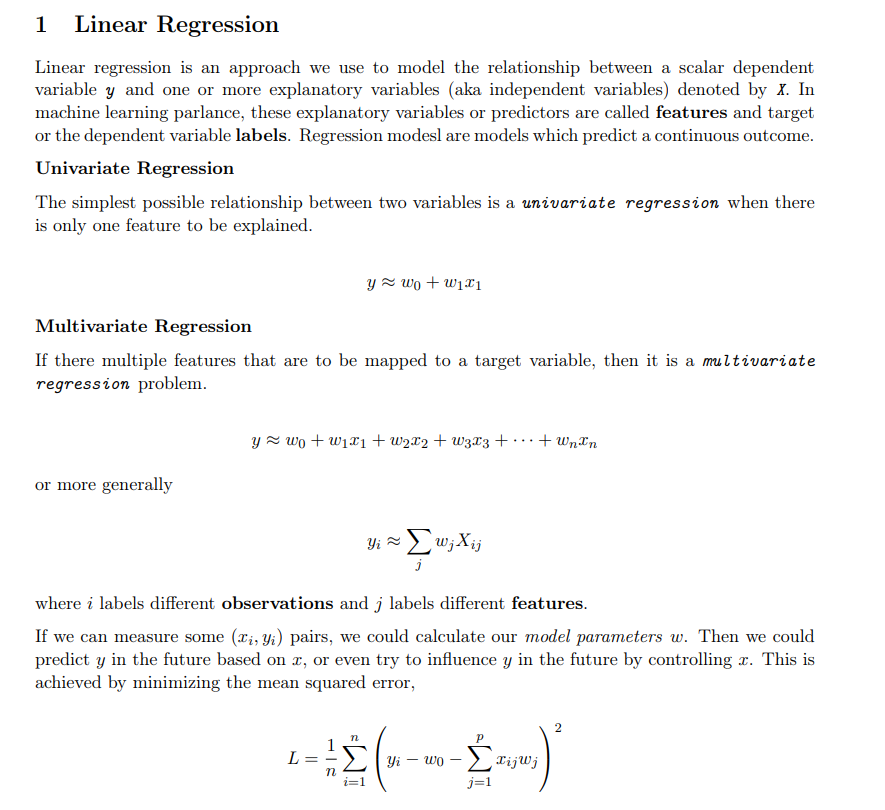

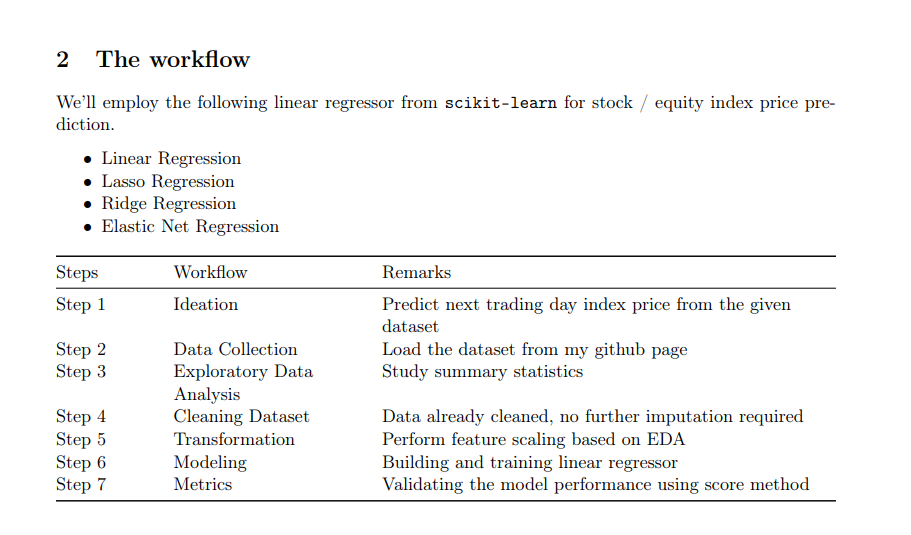

In [1]:
#Importing required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set(rc={'figure.figsize': (20, 8)})


#Data processing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

#Regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')



In [ ]:
print(plt.style.available)

#### 2. Data loading

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv',
index_col=0,
dayfirst=True)
df


,Open,High,Low,Close,Volume
02/01/2012,4640.20,4645.95,4588.05,4636.75,108461000
03/01/2012,4675.80,4773.10,4675.80,4765.30,146621008
04/01/2012,4774.95,4782.85,4728.85,4749.65,165939008
05/01/2012,4749.00,4779.80,4730.15,4749.95,177863008
06/01/2012,4724.15,4794.90,4686.85,4754.10,176057008
...,...,...,...,...,...
26/12/2022,17830.40,18084.10,17774.25,18014.60,176652336
27/12/2022,18089.80,18149.25,17967.45,18132.30,214257088
28/12/2022,18084.75,18173.10,18068.35,18122.50,193873168
29/12/2022,18045.70,18229.70,17992.80,18191.00,281052832


#### 2.2 EDA of the data

In [3]:
df.describe()

,Open,High,Low,Close,Volume
count,2719.000000,2719.000000,2719.000000,2719.00000,2.719000e+03
mean,10124.897959,10175.292074,10057.469787,10117.57100,2.892221e+08
std,3709.607085,3725.526992,3685.305168,3706.94548,1.952768e+08
min,4640.200000,4645.950000,4588.050000,4636.75000,2.826000e+06
25%,7637.000000,7681.000000,7581.650000,7623.80000,1.591780e+08
50%,9376.950000,9431.900000,9301.350000,9351.85000,2.194961e+08
75%,11700.850000,11755.125000,11631.325000,11684.00000,3.409088e+08
max,18871.950000,18887.600000,18778.200000,18812.50000,1.810971e+09


In [4]:
#Cleaing and imputation
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

#### 2.4 Feature Engineering

In [5]:
def create_features(frame):
    df = frame.copy()
    multiplier = 2

    #features
    df['OC'] = df['Close']/df['Open'] - 1
    df['HC'] = df['High']/df['Low'] - 1
    df['GAP'] = df['Close']/df['Open'].shift(1) - 1
    df['RET'] = np.log(df['Close']/df['Close'].shift(1))


    for i in [7, 14, 28]:
        df['PCHG' + str(i)] = df['Close'].pct_change(i)
        df['VCHG' + str(i)] = df['Volume'].pct_change(i)
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] = df['Close'] / df['Close'].rolling(i).mean()
        df['VMA' + str(i)] = df['Volume'] / df['Volume'].rolling(i).mean()
        df['OC'+ str(i)] = df['OC'].rolling(i).mean()
        df['HC'+ str(i)] = df['HC'].rolling(i).mean()
        df['GAP'+ str(i)] = df['GAP'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()
        df['UB'+str(i)] = df['Close'].rolling(i).mean() + df['Close'].rolling(i).std() * multiplier
        df['LB'+str(i)] = df['Close'].rolling(i).mean() - df['Close'].rolling(i).std() * multiplier
        # drop NaN values
    df['Label'] = df['Close'].shift(-1)
    df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df


### Bollinger Bands Overview

Bollinger Bands are a popular technical analysis tool used in trading to measure market volatility and identify potential overbought or oversold conditions. They consist of three components:

#### Components of Bollinger Bands

1. **Middle Band (MA)**
   - Typically a simple moving average (SMA) of the closing price over a specified period.

2. **Upper Band (UB)**
   - Calculated by adding a multiple of the standard deviation to the middle band.

   $$UB = MA + (STD \times Multiplier)$$

3. **Lower Band (LB)**
   - Calculated by subtracting the same multiple of the standard deviation from the middle band.
   $$UB = MA - (STD \times Multiplier)$$

#### Significance of Bollinger Bands

1. **Volatility Measurement**
   - The distance between the upper and lower bands reflects market volatility. Wider bands indicate higher volatility, while narrower bands suggest lower volatility.

2. **Overbought/Oversold Conditions**
   - **Upper Band**: When the price touches the upper band, it may indicate that the asset is overbought, suggesting a potential price correction.
   - **Lower Band**: When the price touches the lower band, it may indicate that the asset is oversold, which could suggest a price increase.

3. **Trend Identification**
   - If prices consistently hit the upper band, it indicates a strong upward trend.
   - If prices hover near the lower band, it suggests a downward trend.

4. **Trading Signals**
   - Traders often use the interaction of price with the bands to make buy or sell decisions:
     - A price closing above the upper band might be a sell signal.
     - A price closing below the lower band could be a buy signal.

In [6]:
df1 = create_features(df)
display(df1.shape)
# verify the output
df1.head(10)


(2690, 38)

,OC,HC,GAP,RET,PCHG7,VCHG7,RET7,MA7,VMA7,OC7,...,RET28,MA28,VMA28,OC28,HC28,GAP28,STD28,UB28,LB28,Label
10/02/2012,-0.003370,0.016233,0.007215,-0.005698,0.027866,-0.040643,0.027485,1.005782,0.945502,0.000784,...,0.148972,1.064556,1.096705,0.002926,0.013767,0.008405,0.010362,5509.527490,4600.976081,5390.20
13/02/2012,0.001505,0.013015,-0.001778,0.001597,0.022828,-0.462772,0.022571,1.004164,0.840571,0.001058,...,0.123222,1.061571,0.878261,0.002296,0.013489,0.007379,0.009437,5534.150356,4620.988930,5416.05
14/02/2012,0.006551,0.009316,0.006308,0.004784,0.016936,-0.073372,0.016794,1.006563,0.942401,0.000647,...,0.131296,1.061685,0.968337,0.002720,0.013414,0.007040,0.009315,5556.516748,4646.222538,5531.95
15/02/2012,0.013066,0.014925,0.028091,0.021174,0.031763,0.461624,0.031269,1.023475,1.379380,0.002987,...,0.152406,1.078500,1.476792,0.003179,0.013572,0.008230,0.009770,5590.919515,4667.676913,5521.95
16/02/2012,0.001487,0.008689,0.011235,-0.001809,0.035013,0.490439,0.034414,1.016606,1.122449,0.005252,...,0.149724,1.070826,1.248959,0.003006,0.013059,0.008593,0.009830,5617.112701,4696.330157,5564.30
17/02/2012,-0.001776,0.011091,0.009168,0.007640,0.036540,0.394575,0.035888,1.019145,1.296951,0.004348,...,0.159744,1.072934,1.478574,0.002978,0.012974,0.008779,0.009720,5641.711320,4730.410109,5607.15
21/02/2012,0.008136,0.010743,0.005911,0.007671,0.035992,-0.094690,0.035359,1.021785,0.922846,0.003657,...,0.145157,1.075585,1.032888,0.002687,0.012701,0.008223,0.009175,5675.798642,4750.437072,5505.35
22/02/2012,-0.018610,0.025240,-0.010167,-0.018322,0.022995,0.167121,0.022735,1.000013,1.028054,0.001480,...,0.124486,1.051415,1.165328,0.002039,0.013340,0.007193,0.010188,5690.174596,4782.089690,5483.30
23/02/2012,-0.001229,0.014027,-0.022541,-0.004013,0.017272,0.692243,0.017125,0.993607,1.122196,0.001089,...,0.126602,1.042568,1.335081,0.002066,0.013355,0.006622,0.010114,5693.780986,4825.058300,5429.30
24/02/2012,-0.009098,0.021366,-0.011065,-0.009897,0.002446,0.810541,0.002443,0.983485,1.227350,-0.001146,...,0.109538,1.028367,1.552348,0.001712,0.013641,0.006042,0.010457,5689.825371,4869.249629,5281.20


In [7]:
# 2.4.2 Label or target Definition
y = np.array(df1['Label'])
y

array([ 5390.2 ,  5416.05,  5531.95, ..., 18122.5 , 18191.  , 18105.3 ])

### 2.4.3 Feature selection

Reduce the number of input variables that are believed to be most useful to a model. We use correlation measures which is one the filter methods to address multicollinearity among features. We will see the correlation between each feature

Text(0.5, 1.0, 'Feature set correlation')

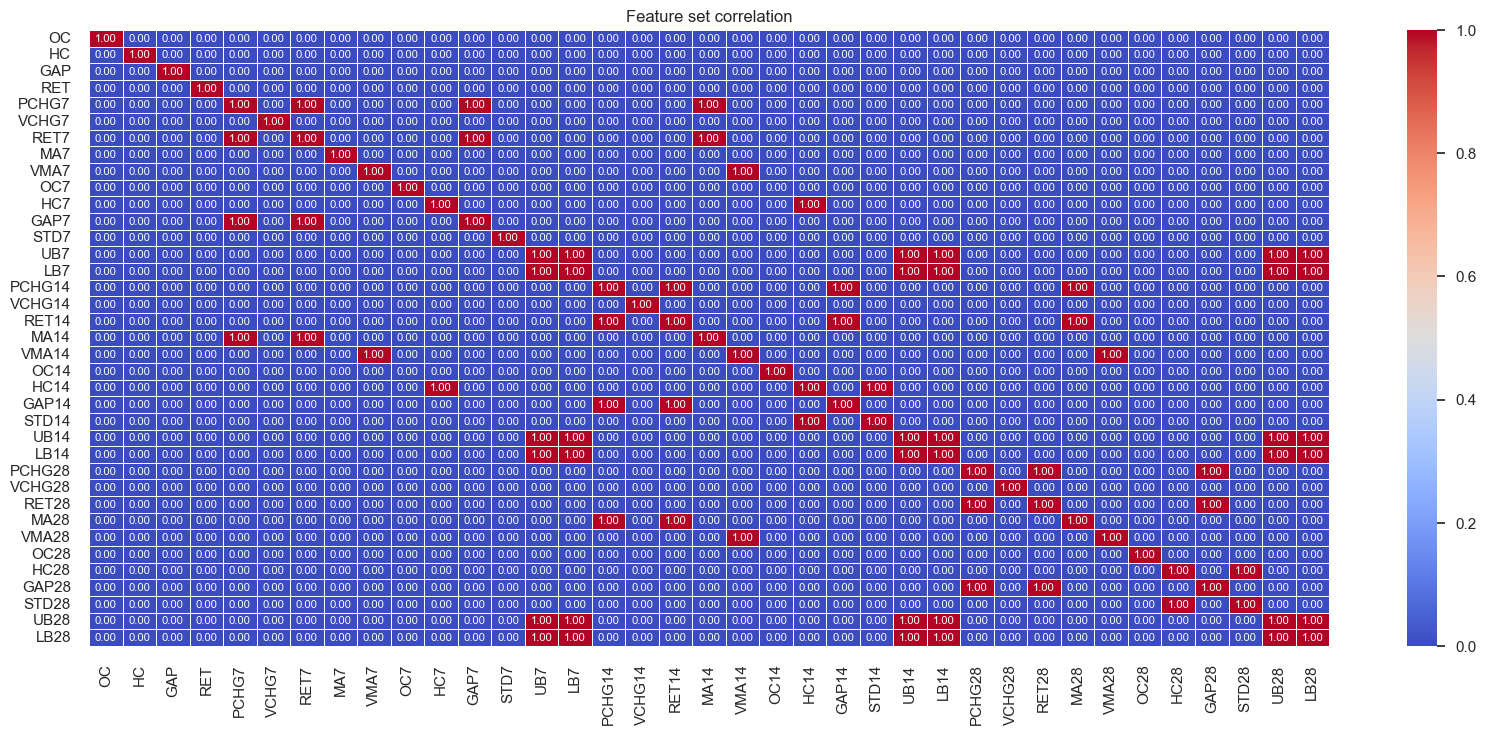

In [8]:
#dropping label from data frame in order to consider only features.

df1.drop('Label', axis = 1, inplace=True )

#Remove features that are highly correlated

sns.heatmap(df1.corr() > 0.9,
            annot=True, annot_kws={"size":8}, fmt=".2f", linewidth = .5, cmap= "coolwarm", cbar=True)

plt.title('Feature set correlation')

In [9]:
# Now I want to drop the feature with correlation greater than 0.9
def correlated_features(data, threshold = 0.9):
    col_corr = set()
    corr_matrix = df1.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range (i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr


In [10]:
#total correlation features
drop_correlated_features = correlated_features(df1)

#now drop the correlated features
X = df1.drop(drop_correlated_features, axis = 1)

#record feature names
feature_names = X.columns

In [11]:
X

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,STD7,UB7,PCHG14,VCHG14,OC14,PCHG28,VCHG28,OC28,HC28
10/02/2012,-0.003370,0.016233,0.007215,-0.005698,0.027866,-0.040643,1.005782,0.945502,0.000784,0.014524,0.006496,5442.198955,0.065959,0.019471,0.001993,0.160641,1.077724,0.002926,0.013767
13/02/2012,0.001505,0.013015,-0.001778,0.001597,0.022828,-0.462772,1.004164,0.840571,0.001058,0.014629,0.006435,5428.626393,0.068160,0.147833,0.001803,0.131136,0.238308,0.002296,0.013489
14/02/2012,0.006551,0.009316,0.006308,0.004784,0.016936,-0.073372,1.006563,0.942401,0.000647,0.013804,0.005661,5438.109364,0.056306,-0.002955,0.001389,0.140305,0.213759,0.002720,0.013414
15/02/2012,0.013066,0.014925,0.028091,0.021174,0.031763,0.461624,1.023475,1.379380,0.002987,0.014252,0.009095,5529.686230,0.072437,0.434309,0.002228,0.164633,0.767461,0.003179,0.013572
16/02/2012,0.001487,0.008689,0.011235,-0.001809,0.035013,0.490439,1.016606,1.122449,0.005252,0.013067,0.008618,5566.125878,0.060955,0.250724,0.002499,0.161513,0.533935,0.003006,0.013059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23/12/2022,-0.009503,0.015239,-0.026355,-0.017841,-0.045739,0.064531,0.976687,1.115709,-0.004985,0.013165,0.008512,18669.003851,-0.047818,-0.232110,-0.002469,-0.032418,-0.117451,-0.000882,0.008980
26/12/2022,0.010331,0.017433,0.002055,0.011602,-0.021738,-0.035359,0.991193,0.894157,-0.001978,0.013594,0.010314,18604.740625,-0.033694,-0.188839,-0.001892,-0.021459,-0.194358,-0.000535,0.009412
27/12/2022,0.002349,0.010118,0.016932,0.006512,-0.007483,-0.228320,0.998743,1.136602,-0.001252,0.013586,0.010633,18577.567284,-0.023070,0.068605,-0.001424,-0.011535,0.068545,-0.000423,0.009569
28/12/2022,0.002087,0.005797,0.001808,-0.000541,-0.016175,0.252027,1.000549,0.998925,-0.001988,0.012949,0.009836,18464.387000,-0.026162,-0.044071,-0.001423,-0.010113,-0.024758,-0.000202,0.009414


In [12]:
X.describe()

,OC,HC,GAP,RET,PCHG7,VCHG7,MA7,VMA7,OC7,HC7,STD7,UB7,PCHG14,VCHG14,OC14,PCHG28,VCHG28,OC28,HC28
count,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000
mean,-0.000679,0.011870,-0.000170,0.000451,0.003593,0.101616,1.001399,1.002380,-0.000680,0.011873,0.009049,10363.305439,0.007386,0.165838,-0.000674,0.015286,0.122934,-0.000665,0.011884
std,0.008894,0.008245,0.013854,0.010769,0.028319,1.947073,0.014663,0.217941,0.003021,0.006103,0.005804,3755.577041,0.040495,4.865908,0.002073,0.056592,2.228693,0.001490,0.004959
min,-0.068180,0.002465,-0.090775,-0.139038,-0.229370,-0.992479,0.870345,0.009408,-0.015850,0.005013,0.001353,4937.648674,-0.316409,-0.990374,-0.010768,-0.367473,-0.991950,-0.007239,0.005870
25%,-0.005109,0.007322,-0.007797,-0.004635,-0.011853,-0.181148,0.993029,0.863296,-0.002462,0.008669,0.005769,7849.833182,-0.013799,-0.199597,-0.001800,-0.016429,-0.209351,-0.001482,0.009056
50%,-0.000522,0.010028,0.000245,0.000687,0.005298,0.002136,1.002947,0.970138,-0.000553,0.010704,0.007983,9681.175472,0.009224,-0.005628,-0.000611,0.018710,-0.011725,-0.000571,0.010971
75%,0.003936,0.013918,0.007609,0.006208,0.019829,0.212967,1.010340,1.103396,0.001248,0.013622,0.010570,11955.617875,0.031227,0.229800,0.000607,0.051332,0.255204,0.000296,0.013382
max,0.093065,0.187519,0.117166,0.084003,0.146336,98.264679,1.065376,2.428776,0.013974,0.090372,0.073491,18937.787117,0.187885,251.176577,0.006110,0.208771,112.871909,0.003501,0.053636


Text(0.5, 1.0, 'Boxplot of features')

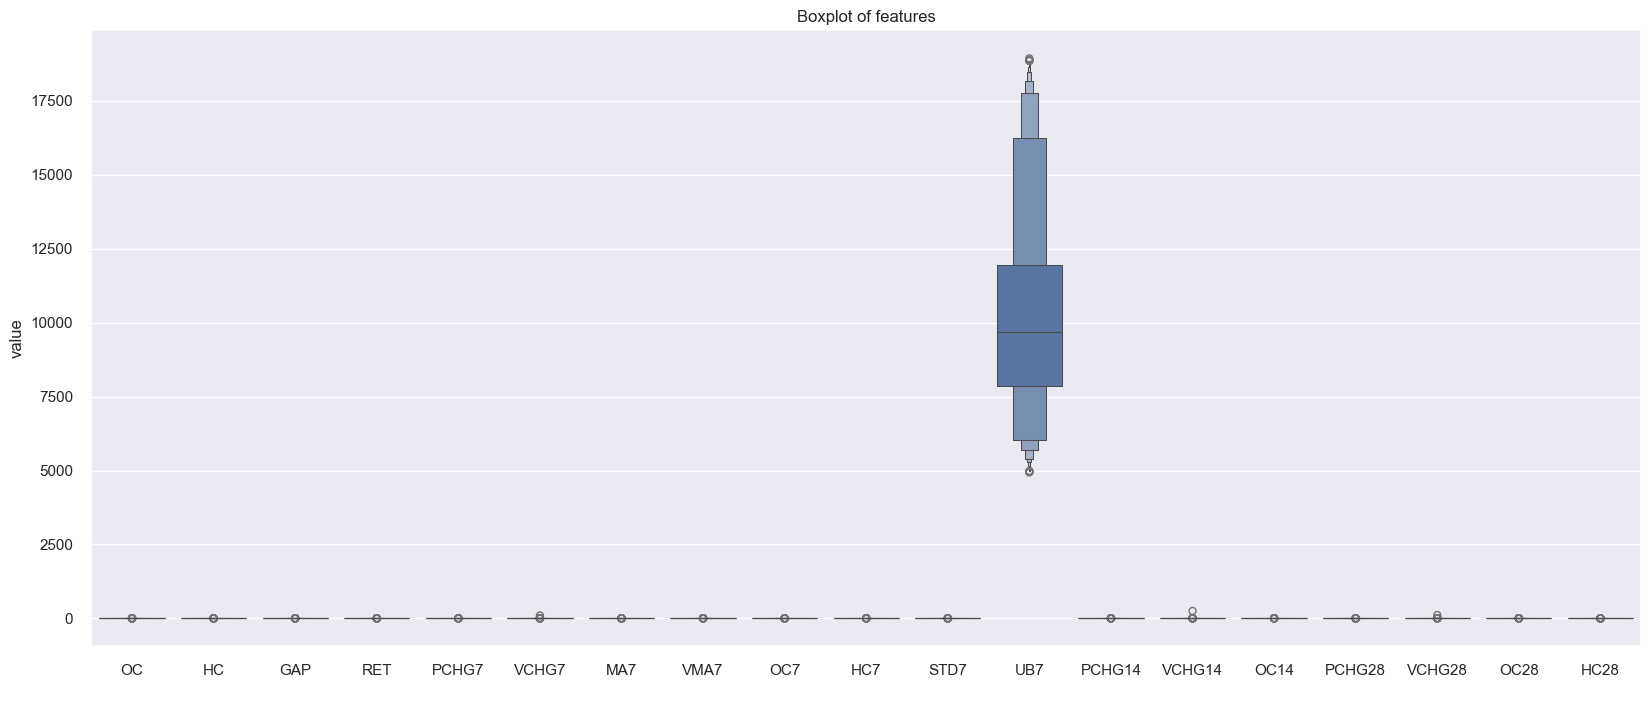

In [13]:
#To see the distribution
sns.boxenplot(x = 'variable', y = 'value', data = pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of features')

### Regrssion Class

In [51]:
class Regression:
    def __init__(self, X, y, testsize=0.20):

        self.X = X
        self.y = y
        self.testsize = testsize

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.testsize, random_state=0, shuffle=False)

    def fit_predict(self, estimator, transformer, alpha=None, l1_ratio=None):
        # Alpha and l1_ratio will be needed for Lasso and Ridge

        try:
            # Create the pipeline
            model = Pipeline([
            ('scaler', transformer),
            ('regressor', estimator)
            ])

            # Fit the model
            model.fit(self.X_train, self.y_train)
            # Predict labels
            y_pred = model.predict(self.X_test)

        except Exception as e:
            print("An error occurred:", str(e))
            

        return model, model['regressor'].intercept_, model['regressor'].coef_, y_pred #, self.y_test
                   
                   
        
        # evaluate metrics
    def eval_metrics(self, model, y_pred):
        # evaluate metrics
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2train = model.score(self.X_train, self.y_train)
        r2test = model.score(self.X_test, self.y_test)
            

        return mse, rmse, r2train, r2test
        
    def plot_coeff(self, modelname):
        coef = []
        model = Regression(self.X, self.y, 0.20)
        alpha_range = np.logspace(2, -2, 200)
    
        if modelname == 'Lasso':
            for i in alpha_range:
                coef.append(model.fit_predict(Lasso(alpha=i, random_state=0), MinMaxScaler())[2])
            
        elif modelname == 'Ridge':
            alpha_range = np.logspace(6, -2, 200)  # Corrected indentation
            for i in alpha_range:
                coef.append(model.fit_predict(Ridge(alpha=i, random_state=0), MinMaxScaler())[2])
            
        elif modelname == 'ElasticNet':
            for i in alpha_range:
                coef.append(model.fit_predict(ElasticNet(alpha=i, random_state=0), MinMaxScaler())[2])


        # Plot Coefficients
        fig = plt.figure(figsize=(20,8))
        ax = plt.axes()
        ax.plot(alpha_range, coef)
        ax.set_xscale('log')
        ax.legend(feature_names, loc=0)
        # ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
        ax.set_title(f'{modelname} coefficients as a function of the regularization')
        ax.set_xlabel('$\lambda$')
        ax.set_ylabel('$\mathbf{w}$')
        return plt.show()









In [36]:
lr = Regression(X, y)

lr_model, lr_intercept, lr_coef, lr_y_pred = lr.fit_predict(LinearRegression(), MinMaxScaler())
print (f"\n Model: {lr_model} \n Intercept: {lr_intercept} \n Coefficients: \n{lr_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', LinearRegression())]) 
 Intercept: 3848.5370530623404 
 Coefficients: 
[ 2.26294136e+01 -3.41867669e+02 -1.31192123e+02  1.21823510e+02
  2.62321259e+02 -1.53181699e+02  1.87154541e+03 -4.81355202e+01
 -4.05637986e+02 -9.72179096e+02 -5.85302064e+02  7.41251472e+03
 -3.63295670e+02  8.51118753e-01  2.33256584e+02  2.69742177e+01
 -1.10714955e+02 -2.06733544e+01  2.87139427e+02]


#### LASSO

The Least Absolute Shrinkage and Selection Operator (LASSO) is a variation of linear regression. In
Lasso, the loss function is minimized by limiting the sum of absolute values of the model coefficients
where the L1 penalty term is added to the Mean Square Error (MSE). The L1 penalty term not
only shrinks the coefficents, but shrinks some of them to zero and that is very useful for feature
selection.

$$L = \frac{1}{n}\sum_{i=1}^{n}\left(y_i - w_0 - \sum_{j=1}^{p}x_{ij}w_j \right)^{2} + \lambda \sum_{j=1}^{p} |w_j|$$

In [37]:
lasso = Regression(X,y)

#fit lasso
lasso_model, lasso_intercept, lasso_coef, lasso_y_pred = lasso.fit_predict(Lasso(alpha=0.3, random_state=0), MinMaxScaler())
print(f"\n Model: {lasso_model} \n Intercept: {lasso_intercept} \n Coefficient: {lasso_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Lasso(alpha=0.3, random_state=0))]) 
 Intercept: 3861.1047180432224 
 Coefficient: [   0.         -252.84122933   -0.            0.            0.
   -0.         1783.56873751  -31.68076915 -152.58196198 -878.15234207
 -468.20978007 7403.10250288    0.           -0.           17.11791644
    0.           -0.            0.          136.09343665]


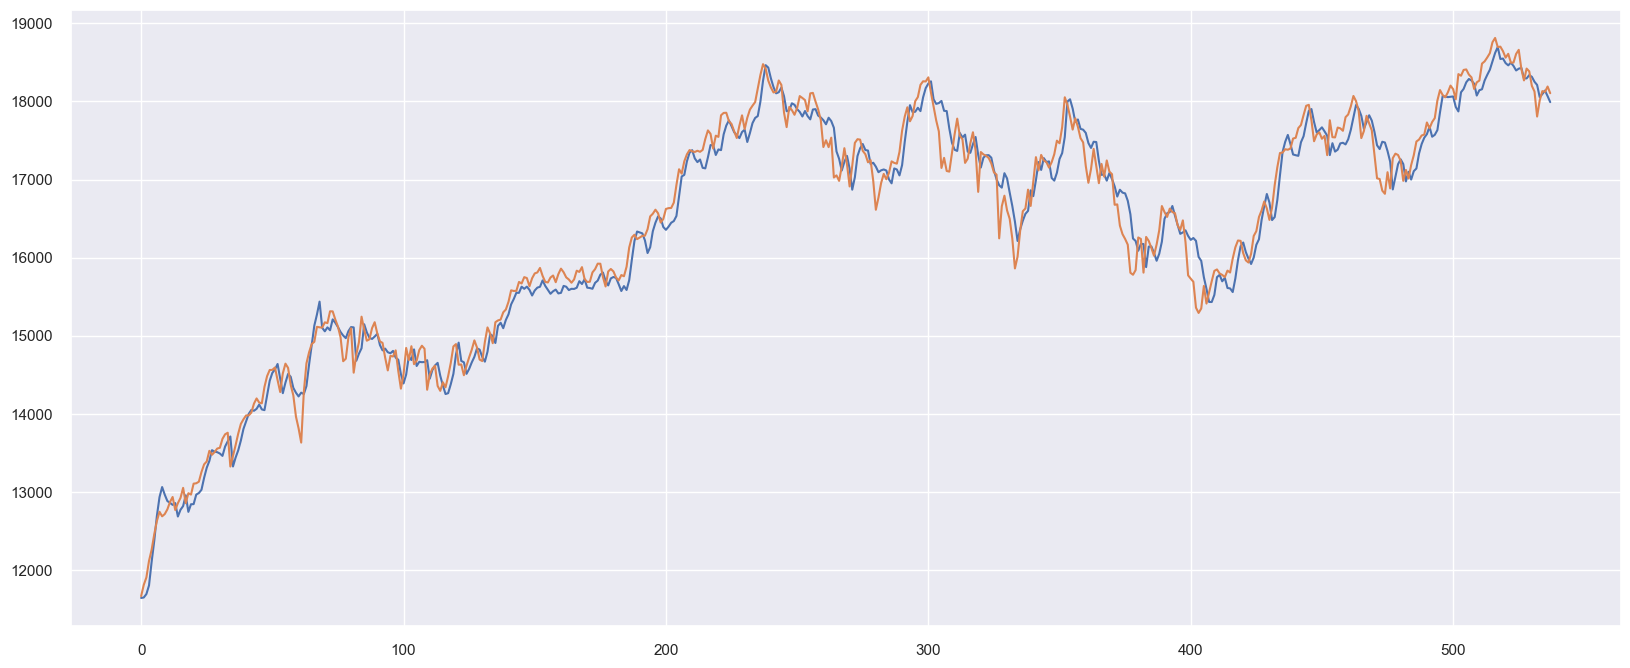

In [31]:
# plt.plot(lasso_y_pred)
# plt.plot(lasso_ytest)

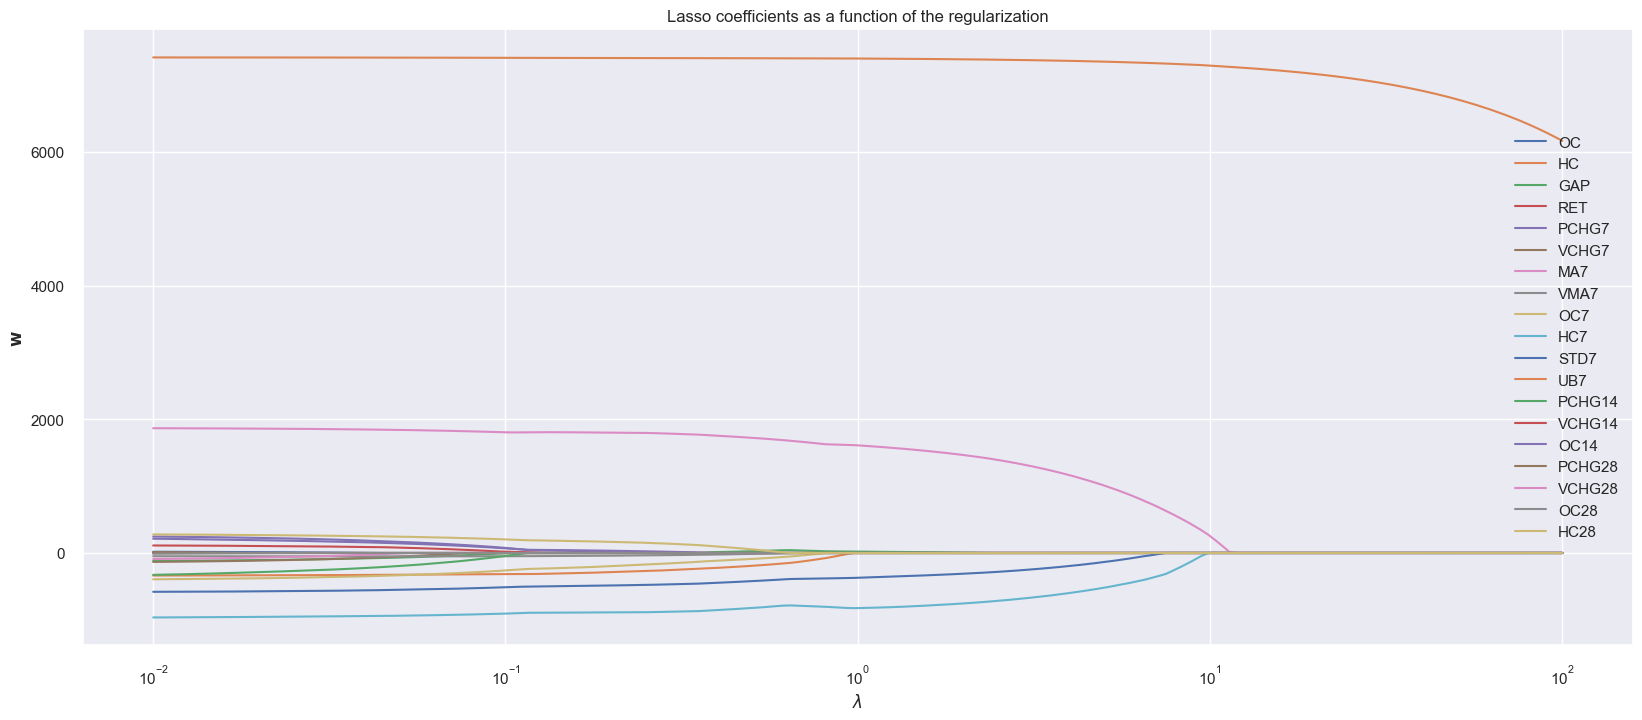

In [38]:
lasso.plot_coeff('Lasso')

#### Ridge

In ridge regression, the cost function is altered by adding a L2 penality equivalent to square of the
magnitude of the coefficients. The Ridge regression shrinks the coefficients and helps to reduce the
multi-collinearity. As seen from the above graph, when λ −→ 0, the cost function becomes similar to
the linear regression cost function.

$$L = \frac{1}{n}\sum_{i=1}^{n}\left(y_i - w_0 - \sum_{j=1}^{p}x_{ij}w_j \right)^{2} + \lambda \sum_{j=1}^{p} w_j^{2}$$

In [39]:
ridge = Regression(X,y)

#fit_Ridge
ridge_model, ridge_intercepter, ridge_coef, ridge_y_pred = ridge.fit_predict(Ridge(alpha=1, random_state=0), MinMaxScaler())

print(f"\n Model: {ridge_model} \n Intercepter: {ridge_intercepter} \n Coefficient: {ridge_coef}")


 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Ridge(alpha=1, random_state=0))]) 
 Intercepter: 3811.8060060850876 
 Coefficient: [  40.37056939 -433.91124573  102.31961209  187.73172425  436.11449093
  -72.10185076 1271.98854277  -44.07589683 -283.44786853 -714.77613479
 -489.68071977 7360.569888      9.33806131   11.79692594   67.78064291
   30.5136396   -58.18546943  -27.72592891  114.04643149]


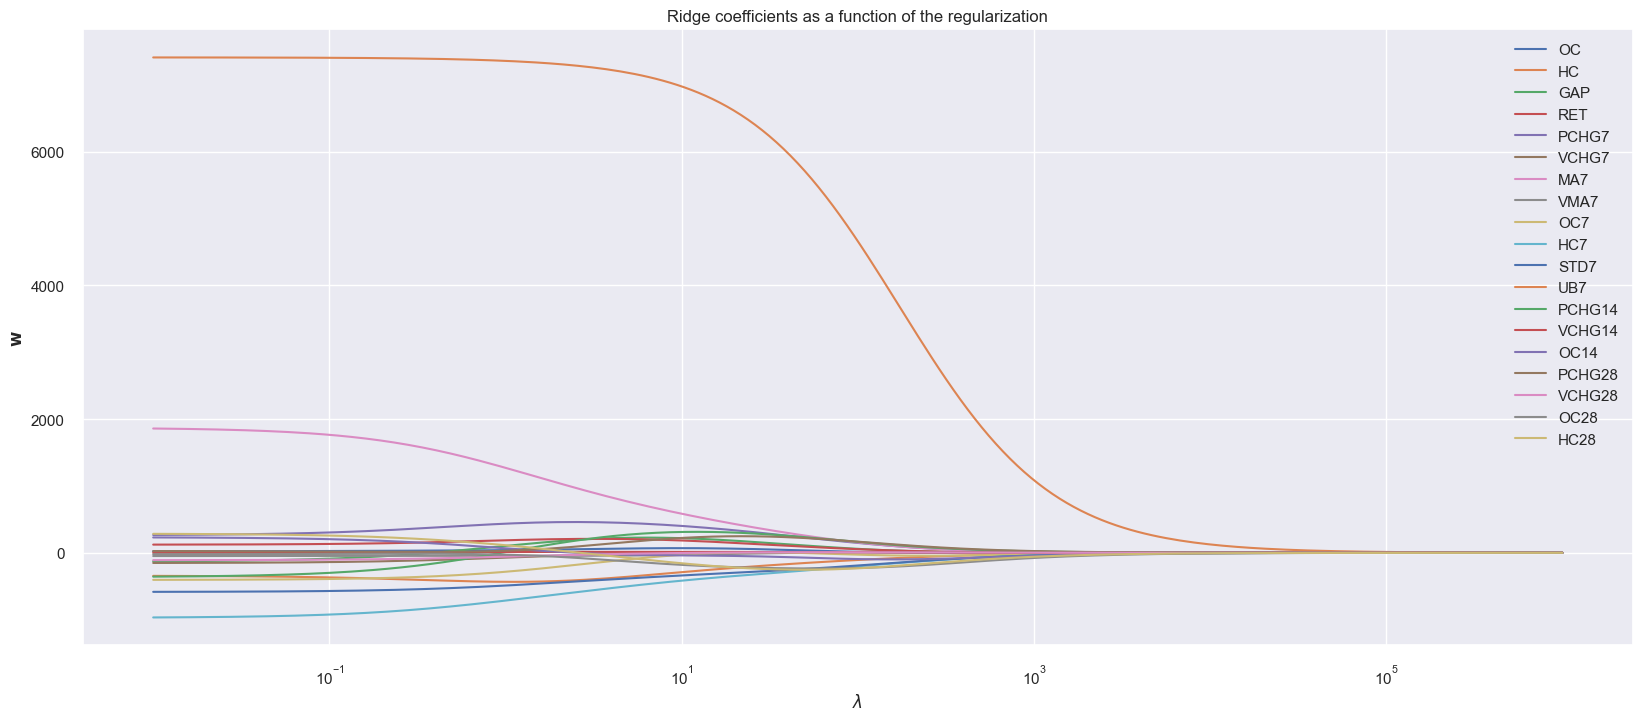

In [40]:
ridge.plot_coeff('Ridge')


#### Elastic Net

ElasticNet combines the properties of both Lasso and Ridge regression. It penalizes the model using
both the L1 and L2 norm.

$$L = \frac{1}{n}\sum_{i=1}^{n}\left(y_i - w_0 - \sum_{j=1}^{p}x_{ij}w_j \right)^{2} + \lambda \left (\frac{1-\alpha}{2} \sum_{j=1}^{p} w_j^{2} + \alpha \sum_{j=1}^{p} |w_j|\right) $$

Where $0 \leq \alpha \leq 1$. Elastic Net is same as Lasso when $\alpha = 1$ and Ridge when $\alpha  = 0$. For other values of $\alpha$, the penulty term interpolate between L1 and L2 norm of the coefficient. 

In [52]:
elasticnet = Regression(X,y)

#fitting
elasticnet_model, elasticnet_intercepter, elasticnet_coef, elasticnet_y_pred = elasticnet.fit_predict(ElasticNet(alpha = 0.1, l1_ratio=1e-10, random_state=0), MinMaxScaler())

print(f"\n Model: {ridge_model} \n Intercepter: {ridge_intercepter} \n Coefficient: {ridge_coef}")



 Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', Ridge(alpha=1, random_state=0))]) 
 Intercepter: 3811.8060060850876 
 Coefficient: [  40.37056939 -433.91124573  102.31961209  187.73172425  436.11449093
  -72.10185076 1271.98854277  -44.07589683 -283.44786853 -714.77613479
 -489.68071977 7360.569888      9.33806131   11.79692594   67.78064291
   30.5136396   -58.18546943  -27.72592891  114.04643149]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


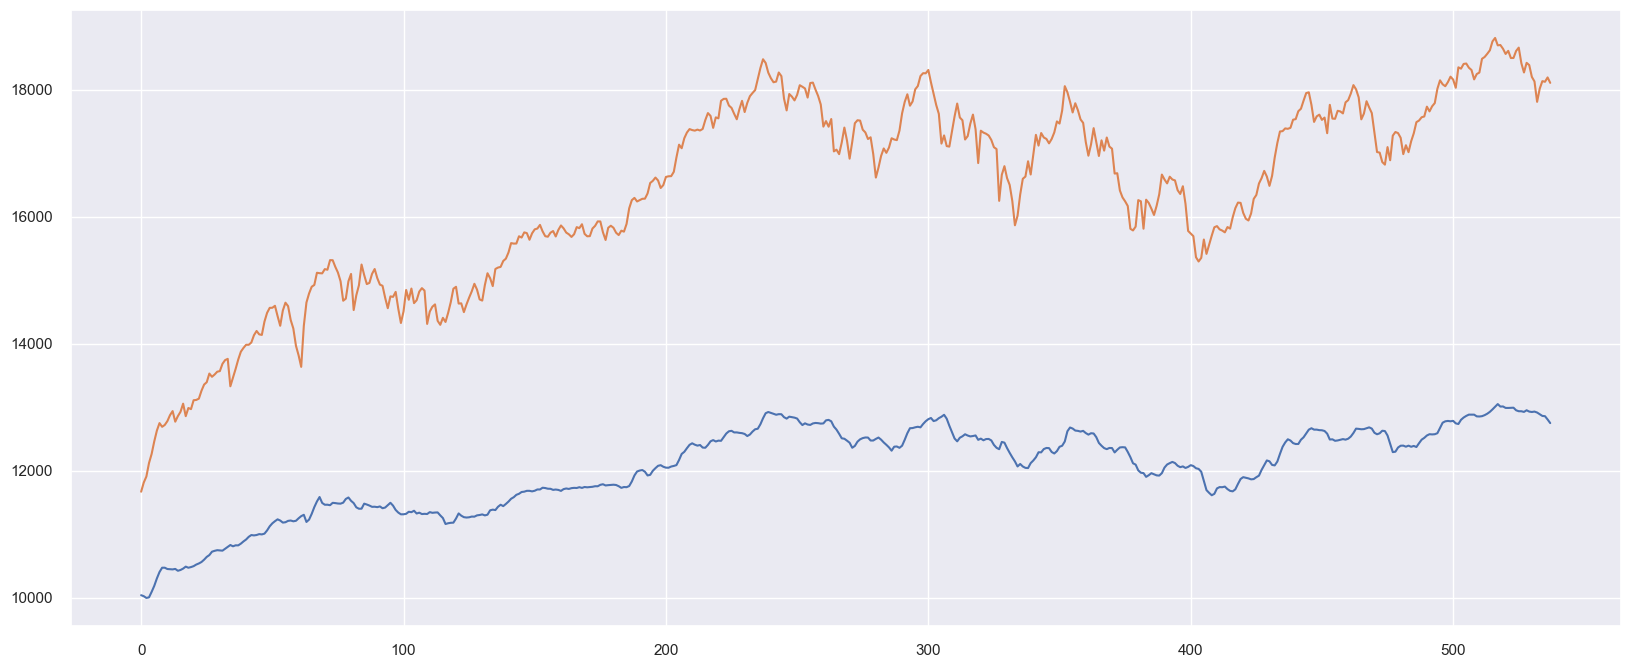

In [49]:
# plt.plot(elasticnet_y_pred)
# plt.plot(elasticnet_y_test)
# plt.legend()

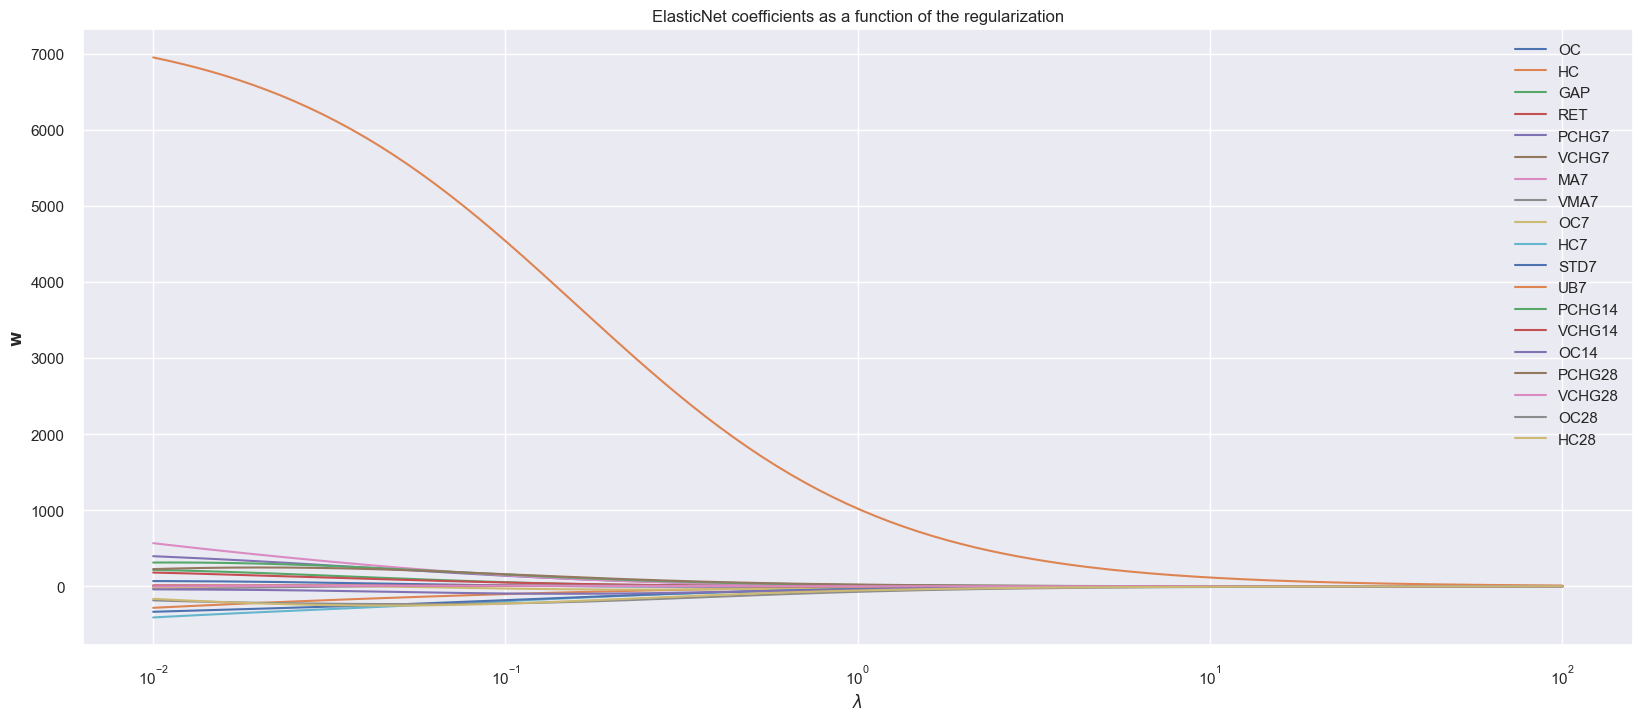

In [42]:
elasticnet.plot_coeff('ElasticNet')

#### Model Comparison

In [43]:
feature_names


Index(['OC', 'HC', 'GAP', 'RET', 'PCHG7', 'VCHG7', 'MA7', 'VMA7', 'OC7', 'HC7',
       'STD7', 'UB7', 'PCHG14', 'VCHG14', 'OC14', 'PCHG28', 'VCHG28', 'OC28',
       'HC28'],
      dtype='object')

In [53]:
coef_df = pd.DataFrame({
    'LR': lr_coef,
    'Lasso': lasso_coef,
    'Ridge': ridge_coef,
    'ElasticNet': elasticnet_coef
}, index=feature_names)

coef_df

,LR,Lasso,Ridge,ElasticNet
OC,22.629414,0.000000,40.370569,0.517144
HC,-341.867669,-252.841229,-433.911246,-65.359709
GAP,-131.192123,-0.000000,102.319612,22.767657
RET,121.823510,0.000000,187.731724,25.671248
PCHG7,262.321259,0.000000,436.114491,77.629864
VCHG7,-153.181699,-0.000000,-72.101851,5.778744
MA7,1871.545408,1783.568738,1271.988543,75.993315
VMA7,-48.135520,-31.680769,-44.075897,11.710873
OC7,-405.637986,-152.581962,-283.447869,-43.016143
HC7,-972.179096,-878.152342,-714.776135,-132.087879


In [55]:
#comparing evaluation matrix
eval_df = pd.DataFrame({
'LR': lr.eval_metrics(lr_model, lr_y_pred),
'Lasso': lasso.eval_metrics(lasso_model, lasso_y_pred),
'Ridge': ridge.eval_metrics(ridge_model, ridge_y_pred),
'ElasticNet': elasticnet.eval_metrics(elasticnet_model, elasticnet_y_pred)
}, index = ['MSE', 'RMSE', 'R2_train', 'R2_test'])
eval_df

,LR,Lasso,Ridge,ElasticNet
MSE,55352.480813,56012.774478,60451.240801,1.950382e+07
RMSE,235.271079,236.670181,245.868340,4.416313e+03
R2_train,0.996430,0.996353,0.996295,6.884570e-01
R2_test,0.976423,0.976142,0.974252,-7.307425e+00
